In [1]:
datadir=r'C:\Users\rohit\Documents\__ml__\Car\CARDATA\Training DATA'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
columns=['center', 'left','right', 'steering', 'throttle','reverse', 'speed']
data=pd.read_csv(os.path.join (datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

C:\Users\rohit\AppData\Local\Temp\ipykernel_44508\2887941390.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


In [4]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


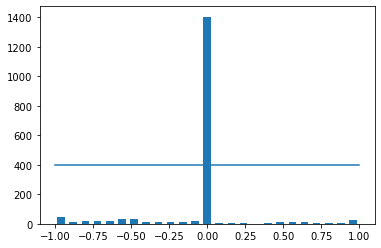

In [5]:
num_bins = 25
samples_per_bin=400
hist,bins=np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

total_data: 1743
removed: 1003
remaining: 740


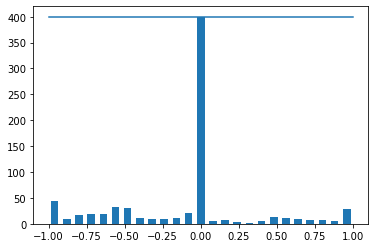

In [6]:
print('total_data:', len(data))
remove_list= []
for j in range(num_bins):
  list_= []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_= list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist,_ =np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [7]:
def load_img_steering(datadir, df):
  image_path= []
  steering= []
  for i in range(len(data)):
    indexed_data= data.iloc[i]
    center, left, right= indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings  = load_img_steering(datadir + '/IMG', data)

 

In [8]:
X_train, X_valid, y_train, y_valid= train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples:{}\nValid Samples:{}'.format(len(X_train), len(X_valid)))

Training Samples:592
Valid Samples:148


Text(0.5, 1.0, 'Validation set')

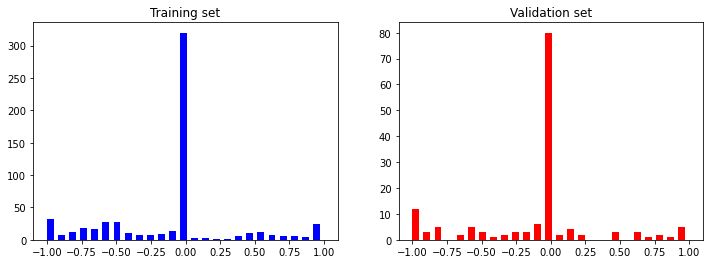

In [9]:
fig, axes= plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red' )
axes[1].set_title('Validation set')

In [10]:
def img_preprocess(img):
  img= mpimg.imread(img)
  img= img[60:135, :, :]
  img= cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img, (3,3), 0)
  img=cv2.resize(img, (200,66))
  img=img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

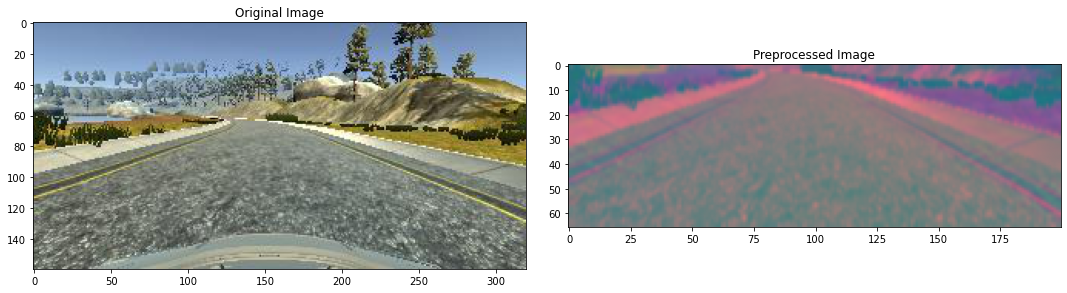

In [11]:
image = image_paths[150]
original_image= mpimg.imread(image)
preprocessed_image= img_preprocess(image)

fig, axs =plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [12]:
X_train=np.array(list(map(img_preprocess, X_train)))
X_valid=np.array(list(map(img_preprocess, X_valid)))

(592, 66, 200, 3)


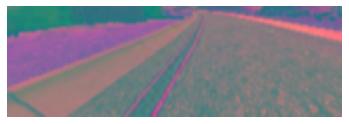

In [13]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis("off")
print(X_train.shape)

In [16]:
def nvidia_model():
    model=tensorflow.keras.Sequential()
    model.add(Convolution2D(24, (5, 5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
    
    model.add(Convolution2D(36, (5, 5), strides=(2,2), activation='elu'))
    
    model.add(Convolution2D(48, (5, 5), strides=(2,2), activation='elu'))

    model.add(Convolution2D(64, (3, 3), activation='elu'))
    
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    optimizer= Adam(lr=0.001)
    model.compile(loss='mse', optimizer=optimizer,metrics=['accuracy'])
    model.summary
    return model

In [17]:
model= nvidia_model()

In [18]:
history=model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30


ValueError: in user code:

    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:394 call
        outputs = layer(inputs, **kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\functional.py:1447 call
        return getattr(self._module, self._method_name)(*args, **kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py:1006 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\keras\layers\convolutional.py:245 call
        outputs = self._convolution_op(inputs, self.kernel)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\nn_ops.py:1012 convolution_v2
        return convolution_internal(
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\nn_ops.py:1142 convolution_internal
        return op(
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\nn_ops.py:2596 _conv2d_expanded_batch
        return gen_nn_ops.conv2d(
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\gen_nn_ops.py:968 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:3557 _create_op_internal
        ret = Operation(
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\rohit\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 5 from 3 for '{{node sequential_1/module_wrapper_23/conv2d_7/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true](sequential_1/module_wrapper_22/max_pooling2d_6/MaxPool, sequential_1/module_wrapper_23/conv2d_7/Conv2D/ReadVariableOp)' with input shapes: [?,3,11,36], [5,5,36,48].


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')